# EDA

## Descripción de las variables

- **ID de encuentro**: Identificador único de un encuentro.
- **Número de paciente**: Identificador único de un paciente.
- **Raza**: Valores posibles: Caucásico, Asiático, Afroamericano, Hispano y Otro.
- **Género**: Valores posibles: masculino, femenino y desconocido/inválido.
- **Edad**: Agrupada en intervalos de 10 años: (0-10), (10-20), ..., (90-100).
- **Peso**: Peso en libras.
- **Tipo de admisión**: Identificador numérico que corresponde a 9 valores distintos, por ejemplo: emergencia, urgente, electiva, recién nacido y no disponible.
- **Disposición al alta**: Identificador numérico que corresponde a 29 valores distintos, por ejemplo: dado de alta a casa, fallecido y no disponible.
- **Fuente de admisión**: Identificador numérico que corresponde a 21 valores distintos, por ejemplo: referencia médica, sala de emergencias y traslado desde otro hospital.
- **Tiempo en el hospital**: Número entero de días entre la admisión y el alta.
- **Código del pagador**: Identificador numérico que corresponde a 23 valores distintos, por ejemplo: Blue Cross/Blue Shield, Medicare y pago propio.
- **Especialidad médica**: Identificador numérico de la especialidad del médico que admitió al paciente. Corresponde a 84 valores distintos, por ejemplo: cardiología, medicina interna, medicina general/familiar y cirugía.
- **Número de pruebas de laboratorio**: Número de exámenes de laboratorio realizados durante el encuentro.
- **Número de procedimientos**: Número de procedimientos (que no sean de laboratorio) realizados durante el encuentro.
- **Número de medicamentos**: Número de nombres genéricos distintos administrados durante el encuentro.
- **Número de visitas ambulatorias**: Número de visitas ambulatorias del paciente en el año anterior al encuentro.
- **Número de visitas de emergencia**: Número de visitas a urgencias del paciente en el año anterior al encuentro.
- **Número de hospitalizaciones previas**: Número de hospitalizaciones del paciente en el año anterior al encuentro.
- **Diagnóstico 1**: Diagnóstico principal (codificado con los primeros tres dígitos de ICD9); 848 valores distintos.
- **Diagnóstico 2**: Diagnóstico secundario (codificado con los primeros tres dígitos de ICD9); 923 valores distintos.
- **Diagnóstico 3**: Diagnóstico secundario adicional (codificado con los primeros tres dígitos de ICD9); 954 valores distintos.
- **Número de diagnósticos**: Número de diagnósticos registrados en el sistema.
- **Resultado del test de glucosa en suero**: Indica el rango del resultado o si no se tomó el examen. Valores: “>200”, “>300”, “normal” y “none” (si no fue medido).
- **Resultado del test A1c**: Indica el rango del resultado o si no se tomó el examen. Valores: “>8”, “>7”, “normal” (si fue menor a 7%) y “none” (si no fue medido).
- **Cambio en medicamentos**: Indica si hubo un cambio en los medicamentos para la diabetes (ya sea en dosis o en el nombre genérico). Valores: “change” y “no change”.
- **Medicamentos para la diabetes**: Indica si se recetó algún medicamento para la diabetes. Valores: “yes” y “no”.
- **24 variables para medicamentos**: Para los nombres genéricos: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone y metformin-pioglitazone. La variable indica si el medicamento fue recetado o si hubo un cambio en la dosis. Valores: “up” (aumentó), “down” (disminuyó), “steady” (sin cambio) y “no” (no fue prescrito).
- **Reingreso**: Días hasta el reingreso hospitalario. Valores: “<30” si el paciente fue reingresado en menos de 30 días, “>30” si fue reingresado en más de 30 días y “No” si no hay registro de reingreso.


## Modelo Logistico

In [2]:
# --- 1. IMPORTAR LIBRERÍAS ---
# Librerías para manipulación de datos, modelado y visualización.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # Para guardar nuestro modelo entrenado

# Clases de Scikit-learn para preprocesamiento, modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    roc_curve, 
    auc
)

In [5]:
# --- 2. CARGA Y PREPARACIÓN DE DATOS ---

# Cargar el dataset desde el archivo CSV
df = pd.read_csv('C:/Users/Jose/Desktop/MachineLearning/jbook/docs/diabetic_data.csv')

# Crear la variable objetivo 'target'.
# Será 1 si el paciente fue reingresado ('<30' o '>30' días), y 0 si no ('NO').
df['target'] = df['readmitted'].isin(['<30', '>30']).astype(int)

# Eliminar columnas que no usaremos: IDs únicos y la columna original de reingreso.
df = df.drop(columns=['encounter_id', 'patient_nbr', 'readmitted'])

In [6]:
# --- 3. DIVISIÓN DE DATOS ---

# Separar las características (X) de la variable objetivo (y).
X = df.drop('target', axis=1)
y = df['target']

# Dividir los datos: 80% para entrenar el modelo y 20% para probarlo.
# 'random_state=42' asegura que la división sea siempre la misma para poder reproducir los resultados.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [7]:
# --- 4. PREPROCESAMIENTO DE CARACTERÍSTICAS ---

# Identificar qué columnas son numéricas y cuáles son categóricas (texto).
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Crear un "transformador" que aplicará diferentes reglas a cada tipo de columna.
# Es una receta de preprocesamiento.
preprocessor = ColumnTransformer(
    transformers=[
        # Paso 1: Para las columnas numéricas, escalarlas a un rango entre 0 y 1.
        ('num', MinMaxScaler(), numeric_features),
        
        # Paso 2: Para las columnas categóricas, convertirlas a números usando One-Hot Encoding.
        # 'handle_unknown='ignore'' evita errores si una categoría aparece en los datos de prueba pero no en los de entrenamiento.
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [8]:
# --- 5. CREACIÓN Y ENTRENAMIENTO DEL MODELO ---

# Crear un 'Pipeline': una secuencia de pasos que se ejecutan en orden.
# 1. 'preprocessor': Aplica la receta de preprocesamiento que definimos antes.
# 2. 'model': Después de preprocesar, entrena el modelo de Regresión Logística.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Entrenar todo el pipeline con los datos de entrenamiento.
print("Entrenando el modelo...")
pipeline.fit(X_train, y_train)
print("¡Modelo entrenado exitosamente!")




Entrenando el modelo...
¡Modelo entrenado exitosamente!



Exactitud del modelo: 0.6296

Reporte de Clasificación:
                precision    recall  f1-score   support

No Reingresado       0.63      0.73      0.68     10952
   Reingresado       0.62      0.51      0.56      9402

      accuracy                           0.63     20354
     macro avg       0.63      0.62      0.62     20354
  weighted avg       0.63      0.63      0.62     20354


Matriz de Confusión:


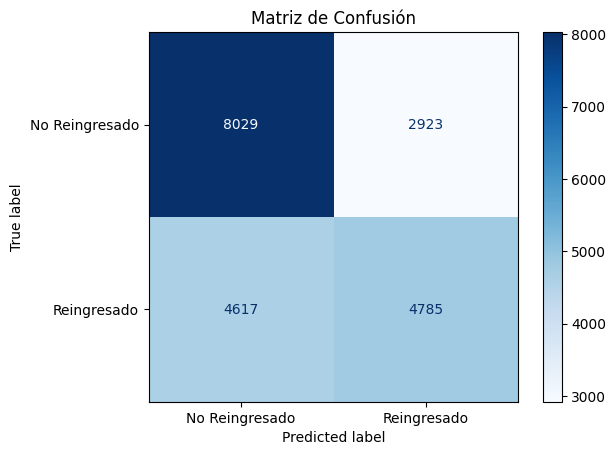

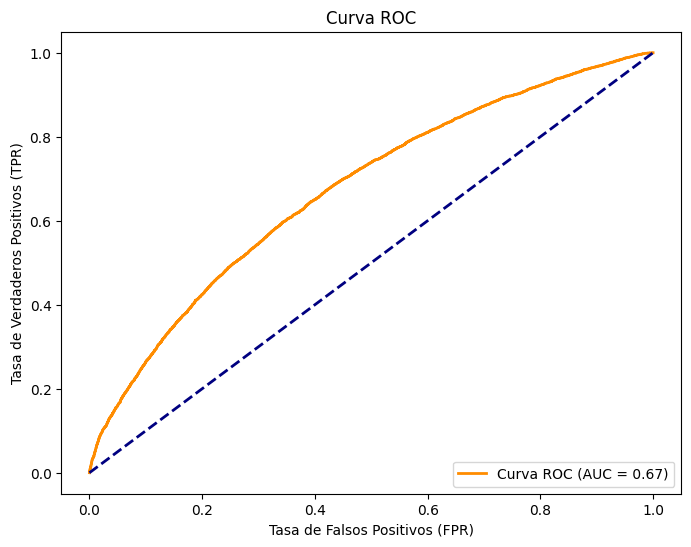

In [9]:
# --- 6. EVALUACIÓN DEL MODELO ---

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba (que nunca ha visto).
y_pred = pipeline.predict(X_test)

# a) Exactitud (Accuracy): ¿Qué porcentaje de predicciones fueron correctas?
accuracy = accuracy_score(y_test, y_pred)
print(f"\nExactitud del modelo: {accuracy:.4f}")

# b) Reporte de Clasificación: Métricas detalladas como Precisión, Recall y F1-Score.
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Reingresado', 'Reingresado']))

# c) Matriz de Confusión: Muestra visualmente los aciertos y errores.
# - Verdaderos Negativos (TN): predijo 'No Reingresado' y era correcto.
# - Falsos Positivos (FP): predijo 'Reingresado' pero era incorrecto.
# - Falsos Negativos (FN): predijo 'No Reingresado' pero era incorrecto (el error más costoso).
# - Verdaderos Positivos (TP): predijo 'Reingresado' y era correcto.
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Reingresado', 'Reingresado'])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

# d) Curva ROC y AUC: Mide la capacidad del modelo para distinguir entre las dos clases.
# Un AUC cercano a 1.0 es excelente. Un AUC de 0.5 es un modelo que adivina al azar.
y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva (Reingresado)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea de referencia (azar)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [10]:
# --- 7. GUARDAR EL MODELO ENTRENADO ---

# Guardar el pipeline completo (preprocesador + modelo) en un archivo.
# Así, podemos cargarlo más tarde para hacer nuevas predicciones sin tener que reentrenar.
with open("modelo_logistico_diabetes.pkl", "wb") as file:
    pickle.dump(pipeline, file)

print("\nModelo guardado exitosamente como 'modelo_logistico_diabetes.pkl'")


Modelo guardado exitosamente como 'modelo_logistico_diabetes.pkl'
